# Análisis Comparativo de Modelos SVM y CNN para Clasificación de Imágenes con Explicabilidad mediante Grad-CAM

- Integrantes: Felipe Peralta, Samantha Suquilanda

In [84]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

## Rutas del dataset y selección de clases

In [ ]:
base_dir = './data/fruits-360_100x100/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

classes_to_use = ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1']
print(f"Clases seleccionadas: {classes_to_use}")

Clases seleccionadas: ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1']


## Normalización

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Cargar los datos de entrenamiento y validación

In [31]:
# Cargar entrenamiento
print("Cargando imágenes de entrenamiento...")
train_generator = datagen.flow_from_directory(
    train_dir,                  
    target_size=(100, 100),     
    batch_size=32,              
    class_mode='categorical', 
    subset='training',          # Pedir la parte de entrenamiento
    classes=classes_to_use,     
    shuffle=True                
)

# Cargar validación
print("Cargando imágenes de validación...")
val_generator = datagen.flow_from_directory(
    train_dir,                
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation',        # Pedir la parte reservada para validar
    classes=classes_to_use,
    shuffle=True
)

Cargando imágenes de entrenamiento...
Found 1572 images belonging to 4 classes.
Cargando imágenes de validación...
Found 392 images belonging to 4 classes.


## Verificación visual

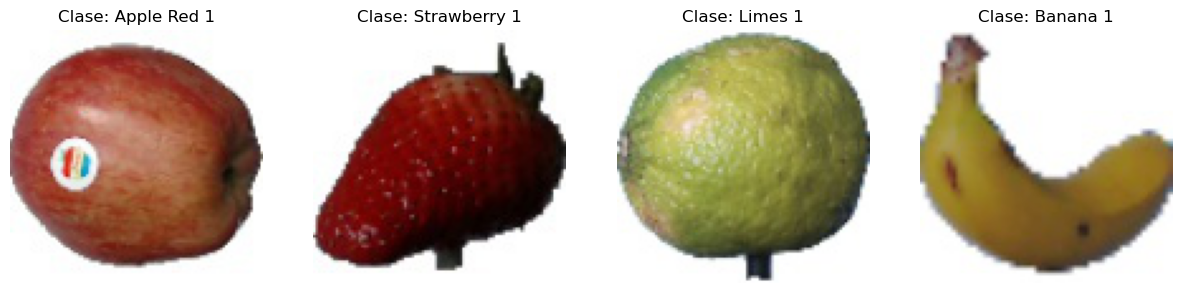

In [ ]:
train_generator.reset()
x_batch, y_batch = train_generator[0]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"Clase: {class_name}")
    axes[i].axis('off')
plt.show()

## SVM

### Convertir datos para SVM

In [34]:
def get_data_from_generator(generator):
    generator.reset()
    X_data, y_data = [], []
    
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X_data.append(X_batch)
        y_data.append(y_batch)
        
    return np.concatenate(X_data), np.concatenate(y_data)

In [35]:
print("Convirtiendo datos para SVM...")
X_train, y_train_cat = get_data_from_generator(train_generator)
X_test, y_test_cat = get_data_from_generator(val_generator)

num_pixels = 100 * 100 * 3
X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

y_train_indices = np.argmax(y_train_cat, axis=1)
y_test_indices = np.argmax(y_test_cat, axis=1)

print(f"Dimensiones para SVM: {X_train_flat.shape}")
print(f"Clases únicas en entrenamiento: {np.unique(y_train_indices)}")
print(f"Distribución de clases en train: {np.bincount(y_train_indices)}")
print(f"Clases únicas en test: {np.unique(y_test_indices)}")
print(f"Distribución de clases en test: {np.bincount(y_test_indices)}")

Convirtiendo datos para SVM...
Dimensiones para SVM: (1572, 30000)
Clases únicas en entrenamiento: [0 1 2 3]
Distribución de clases en train: [394 392 392 394]
Clases únicas en test: [0 1 2 3]
Distribución de clases en test: [98 98 98 98]


### Entrenamiento y evaluación del modelo SVM

In [36]:
print("Entrenando SVM...")

# Crear el modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Entrenar
svm_model.fit(X_train_flat, y_train_indices)

Entrenando SVM...


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [37]:
# Evaluar
y_pred_svm = svm_model.predict(X_test_flat)
print("--- Resultados SVM ---")
print(f"Accuracy: {accuracy_score(y_test_indices, y_pred_svm):.2f}")
print(classification_report(y_test_indices, y_pred_svm, target_names=classes_to_use))

--- Resultados SVM ---
Accuracy: 1.00
              precision    recall  f1-score   support

 Apple Red 1       1.00      1.00      1.00        98
    Banana 1       1.00      1.00      1.00        98
     Limes 1       1.00      1.00      1.00        98
Strawberry 1       1.00      1.00      1.00        98

    accuracy                           1.00       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      1.00      1.00       392



## CNN

### Construcción del modelo CNN

In [ ]:
cnn_model = Sequential([
    # Capa Convolucional 1: Aprende bordes y colores simples
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    
    # Capa Convolucional 2: Aprende formas más complejas
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Capa Convolucional 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Aplanado y Capas Densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Ayuda a evitar el overfitting
    
    # Capa de Salida: Tantas neuronas como clases tengamos
    Dense(len(classes_to_use), activation='softmax')
])

### Compilación

In [ ]:
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 10, 10, 128)      

### Entrenamiento

In [ ]:
print("\nEntrenando CNN...")
history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Entrenando CNN...
Epoch 1/10
50/50 [==============================] - 5s 98ms/step - loss: 0.2869 - accuracy: 0.8760 - val_loss: 0.0193 - val_accuracy: 0.9923
Epoch 2/10
50/50 [==============================] - 5s 95ms/step - loss: 0.0088 - accuracy: 0.9987 - val_loss: 2.8843e-04 - val_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 6s 120ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 1.3154e-04 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 7s 149ms/step - loss: 4.6865e-04 - accuracy: 1.0000 - val_loss: 8.1209e-04 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 8s 153ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 7s 147ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 2.7526e-04 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 7s 147ms/step - loss: 3.6928e-04 - accuracy: 1.0000 - val_l

### Visualización


Generando gráficas de rendimiento...


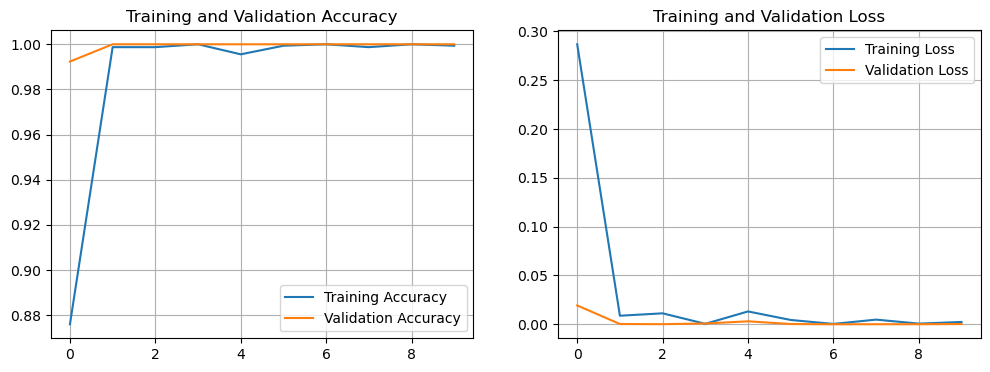

In [41]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Gráfica de Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

print("\nGenerando gráficas de rendimiento...")
plot_history(history)

In [78]:
print("Generando predicciones de la CNN para comparar...")
preds_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.argmax(preds_cnn, axis=1)

Generando predicciones de la CNN para comparar...
13/13 [==============================] - 0s 32ms/step


## Comparación de modelos

Comparación de Matrices de Confusión


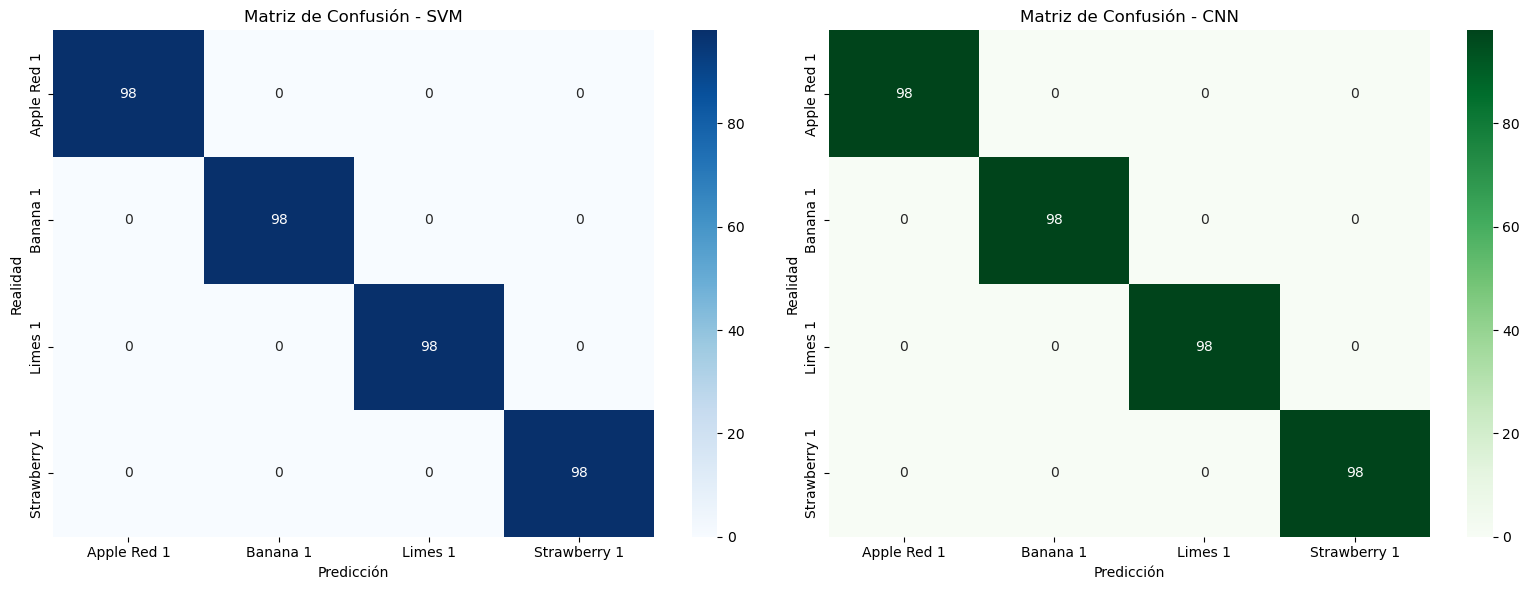

In [82]:
def plot_confusion_matrices(y_true, y_pred_svm, y_pred_cnn, classes):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz SVM
    cm_svm = confusion_matrix(y_true, y_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title('Matriz de Confusión - SVM')
    axes[0].set_ylabel('Realidad')
    axes[0].set_xlabel('Predicción')

    # Matriz CNN
    cm_cnn = confusion_matrix(y_true, y_pred_cnn)
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
                xticklabels=classes, yticklabels=classes)
    axes[1].set_title('Matriz de Confusión - CNN')
    axes[1].set_ylabel('Realidad')
    axes[1].set_xlabel('Predicción')

    plt.tight_layout()
    plt.show()

print("Comparación de Matrices de Confusión")
plot_confusion_matrices(y_test_indices, y_pred_svm, y_pred_cnn, classes_to_use)

Comparación de Métricas


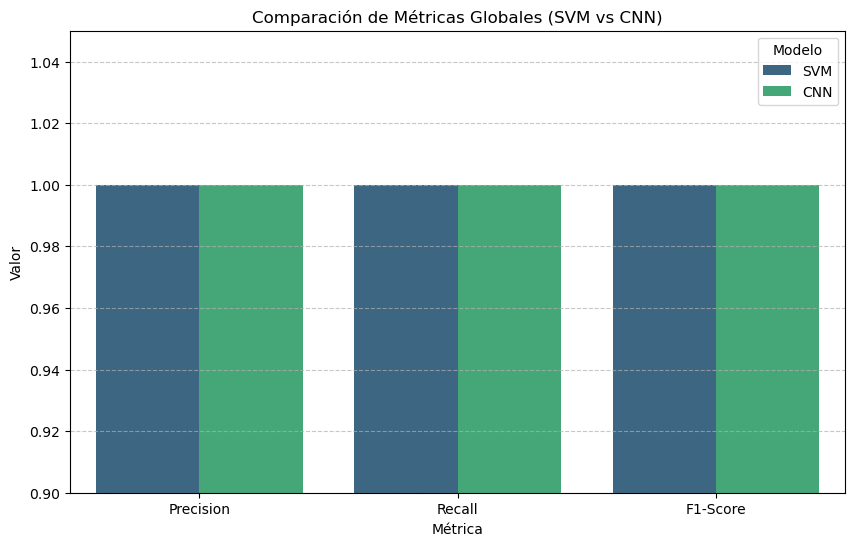

     Métrica  Valor Modelo
0  Precision    1.0    SVM
1     Recall    1.0    SVM
2   F1-Score    1.0    SVM
3  Precision    1.0    CNN
4     Recall    1.0    CNN
5   F1-Score    1.0    CNN


In [85]:
from sklearn.metrics import precision_recall_fscore_support

def plot_metrics_comparison(y_true, y_pred_svm, y_pred_cnn):
    # Calculamos métricas promedio (weighted)
    svm_metrics = precision_recall_fscore_support(y_true, y_pred_svm, average='weighted')
    cnn_metrics = precision_recall_fscore_support(y_true, y_pred_cnn, average='weighted')
    
    # Creamos un DataFrame para facilitar el plot
    metrics_df = pd.DataFrame({
        'Métrica': ['Precision', 'Recall', 'F1-Score', 'Precision', 'Recall', 'F1-Score'],
        'Valor': [svm_metrics[0], svm_metrics[1], svm_metrics[2], 
                  cnn_metrics[0], cnn_metrics[1], cnn_metrics[2]],
        'Modelo': ['SVM', 'SVM', 'SVM', 'CNN', 'CNN', 'CNN']
    })
    
    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df, x='Métrica', y='Valor', hue='Modelo', palette="viridis")
    plt.ylim(0.9, 1.05) # Hacemos zoom en la parte superior porque tus modelos son muy buenos
    plt.title('Comparación de Métricas Globales (SVM vs CNN)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return metrics_df

print("Comparación de Métricas")
df_metrics = plot_metrics_comparison(y_test_indices, y_pred_svm, y_pred_cnn)
print(df_metrics)

## Análisis de Explicabilidad (XAI) con Grad-CAM

In [42]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Guardar la activación original de la última capa
    last_layer = model.layers[-1]
    original_activation = last_layer.activation
    
    # Cambiar la activación a lineal para obtener los "logits"
    last_layer.activation = tf.keras.activations.linear
    
    # Construir el modelo de gradiente con la activación lineal
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Grabar el gradiente
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calcular el gradiente
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar canales por importancia
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Restaurar la activación original del modelo
    last_layer.activation = original_activation

    # Normalización y limpieza
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.math.reduce_max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap.numpy()

In [43]:
def predecir_y_explicar(ruta_imagen, model, classes):
    img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    preds = model.predict(img_array)
    idx_pred = np.argmax(preds[0])
    label_pred = classes[idx_pred]
    confianza = preds[0][idx_pred]

    print(f"Predicción: {label_pred} ({confianza*100:.2f}%)")

    # Generar el heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Visualización
    heatmap_resized = cv2.resize(heatmap, (100, 100))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    
    img_original_uint8 = np.uint8(255 * img_array[0])
    
    # Superposición
    superimposed_img = cv2.addWeighted(img_original_uint8, 0.6, heatmap_colored, 0.4, 0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_array[0])
    ax[0].set_title("Imagen Original")
    
    # Mostrar el heatmap
    ax[1].imshow(heatmap, cmap='jet')
    ax[1].set_title("Activación (Raw)")
    
    ax[2].imshow(superimposed_img)
    ax[2].set_title(f"Explicación: {label_pred}")
    plt.show()

In [45]:
def get_last_conv_layer_name(model):
    # Buscar la última capa convolucional para conectar el Grad-CAM
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No se encontró capa convolucional")

last_conv_layer = get_last_conv_layer_name(cnn_model)
print(f"Capa Convolucional detectada para análisis: {last_conv_layer}")

Capa Convolucional detectada para análisis: conv2d_17


## Ejecución de casos de prueba

Caso 1: Banana
1/1 [==============================] - 0s 16ms/step
Predicción: Banana 1 (100.00%)


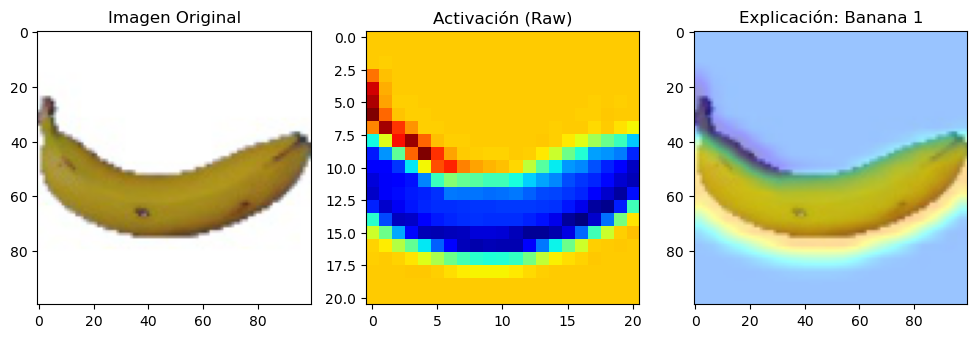

In [73]:
# CASO 1: Banana
print("Caso 1: Banana")
ruta_caso1 = "./data/fruits-360_100x100/fruits-360/Test/Banana 1/100_100.jpg"
if not os.path.exists(ruta_caso1):
    print(f"No se encontró la imagen en {ruta_caso1}")
else:
    predecir_y_explicar(ruta_caso1, cnn_model, classes_to_use)

Caso 2: Fresa
1/1 [==============================] - 0s 27ms/step
Predicción: Strawberry 1 (100.00%)


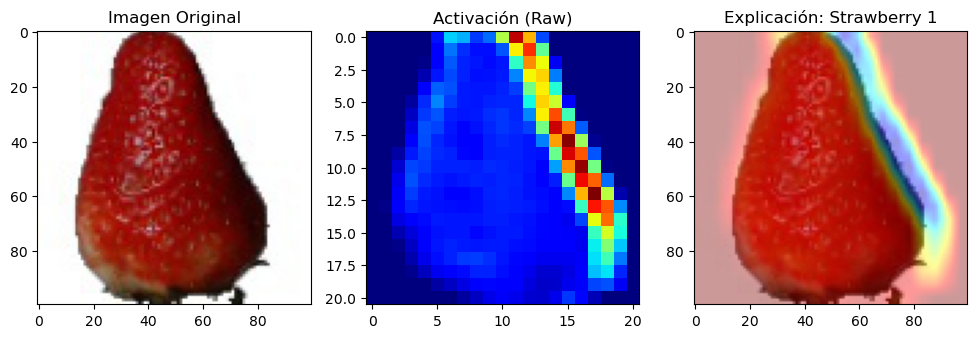

In [77]:
# CASO 2: Fresa
print("Caso 2: Fresa")
ruta_caso2 = "./data/fruits-360_100x100/fruits-360/Test/Strawberry 1/45_100.jpg"
if not os.path.exists(ruta_caso2):
    print(f"No se encontró la imagen en {ruta_caso2}")
else:
    predecir_y_explicar(ruta_caso2, cnn_model, classes_to_use)